In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import albumentations as A
import focal_loss
import datetime

from PIL import Image
from tensorflow import keras

gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus :
    try :
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e :
        print(e)


In [2]:
def plotKeyPoint(image, keypoint) :
    plt.figure(figsize=(120, 80))
    plt.subplot(5, 1, 3)
    for j in range(0,keypoint.shape[0], 2):
        plt.plot(keypoint[j], keypoint[j+1],'rx')
        plt.imshow(image)

def coordScaler(dataFrame, x_scale, y_scale,  x_columns, y_columns) :
    dataFrame.loc[:, dataFrame.columns[x_columns]] = ((dataFrame.loc[:, dataFrame.columns[x_columns]]) / 1920) * x_scale
    dataFrame.loc[:, dataFrame.columns[y_columns]] = ((dataFrame.loc[:, dataFrame.columns[y_columns]]) / 1080) * y_scale
    return dataFrame

trainTarget = pd.read_csv("./RawData/train_df.csv")
target_size = (256, 256)
batch_size = 4

x_coord = [i.endswith("x") for i in trainTarget.columns]
y_coord = [i.endswith("y") for i in trainTarget.columns]
parts = np.array([i[:-2] for i in trainTarget.columns[1:].values.reshape(-1, 2)[:, 0]])

trainTarget = coordScaler(trainTarget, target_size[0], target_size[1], x_coord, y_coord)

In [3]:
data_paths = glob.glob('./RawData/train_imgs/*.jpg')
data_paths = [i.split("\\")[1] for i in data_paths]

train_paths = np.random.choice(data_paths, replace = False, size = int(len(data_paths) * 0.7))
valid_paths = np.setdiff1d(data_paths, train_paths, assume_unique = True)

test_paths = glob.glob('./RawData/test_imgs/*.jpg')
test_paths = [i.split("\\")[1] for i in test_paths]

def DataGenerator(train_paths):
    for i in train_paths.astype(str):
        img = keras.preprocessing.image.load_img("./RawData/train_imgs/" + i, target_size = target_size)
        
        img = keras.preprocessing.image.img_to_array(img)
        target = trainTarget.loc[trainTarget["image"] == i]
               
        transformer = A.Compose([A.Normalize(),
                                 A.RandomBrightnessContrast(), 
                                 A.RandomRotate90(),
                                 A.HorizontalFlip(),
                                 A.VerticalFlip()],
                                 keypoint_params = A.KeypointParams(format='xy'))
        transformed = transformer(image = img, keypoints = target.reshape(-1, 2))       
                
        yield (transformed["image"], np.array(transformed["keypoints"]).reshape(-1))
        
trainData = tf.data.Dataset.from_generator(DataGenerator, (tf.float32, tf.float32), (tf.TensorShape([target_size[0], target_size[1], 3]),tf.TensorShape([48])), args = [train_paths])
trainData = trainData.shuffle(1500).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

validData = tf.data.Dataset.from_generator(DataGenerator, (tf.float32, tf.float32), (tf.TensorShape([target_size[0], target_size[1], 3]),tf.TensorShape([48])), args = [valid_paths])
validData = validData.shuffle(1500).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)


In [4]:
data_paths = glob.glob('./RawData/train_imgs/*.jpg')
data_paths = [i.split("\\")[1] for i in data_paths]

train_paths = np.random.choice(data_paths, replace = False, size = int(len(data_paths) * 0.7))
valid_paths = np.setdiff1d(data_paths, train_paths, assume_unique = True)

test_paths = glob.glob('./RawData/test_imgs/*.jpg')
test_paths = [i.split("\\")[1] for i in test_paths]

def DataGenerator(train_paths):
    for i in train_paths.astype(str):
        img = keras.preprocessing.image.load_img("./RawData/train_imgs/" + i, target_size = target_size)
        
        img = keras.preprocessing.image.img_to_array(img)
        target = trainTarget.loc[trainTarget["image"] == i].iloc[:, 1:].values.reshape(-1)
               
        transformer = A.Compose([A.Normalize(),
                                 A.RandomBrightnessContrast(), 
                                 A.RandomRotate90(),
                                 A.HorizontalFlip(),
                                 A.VerticalFlip()],
                                 keypoint_params = A.KeypointParams(format='xy'))
        
        transformed = transformer(image = img, keypoints = target.reshape(-1, 2))
        
        coords = np.array(transformed["keypoints"])
        
        heatmap = np.array([np.exp( - ((x - part[0]) ** 2 + (y - part[1]) ** 2) / 5.)
                            for part in coords for x in range(target_size[0]) for y in range(target_size[1])]).reshape(len(parts), target_size[1], -1)
        heatmap = np.transpose(heatmap)
        
        bbox_x1, bbox_y1 = coords[:, 0].min(), coords[:, 1].min()
        bbox_x2, bbox_y2 = coords[:, 0].max(), coords[:, 1].max()
        boxes = np.array([[bbox_x1, bbox_y1, bbox_x2, bbox_y2]], dtype = np.int64).reshape(-1)
                
        yield (transformed["image"], (heatmap, boxes))
        
trainData = tf.data.Dataset.from_generator(DataGenerator,
                                           (tf.float32, (tf.float32, tf.float32)),
                                           (tf.TensorShape([target_size[0], target_size[1], 3]), (tf.TensorShape([target_size[0], target_size[1], len(parts)]), tf.TensorShape([4]))),
                                           args = [train_paths])
trainData = trainData.shuffle(1500).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

validData = tf.data.Dataset.from_generator(DataGenerator,
                                           (tf.float32, (tf.float32, tf.float32)),
                                           (tf.TensorShape([target_size[0], target_size[1], 3]), (tf.TensorShape([target_size[0], target_size[1], len(parts)]), tf.TensorShape([4]))),
                                           args = [valid_paths])
validData = validData.shuffle(1500).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)


In [5]:
class MCDropout(keras.layers.Dropout) :
    def call(self, inputs) :
        return suerp().call(inputs, training = True)
    
class HourGlassLayerUnit(keras.layers.Layer) :
    def __init__(self, filters, pooling = True, strides = 1, dropout = None, activation = "relu", **kwargs) :
        super().__init__(**kwargs)
        
        self.dropout_1 = None
        self.dropout_2 = None
        self.dropout_3 = None

        if dropout is not None :
            self.dropout_1 = MCDropout(rate = dropout)
            self.dropout_2 = MCDropout(rate = dropout)
            self.dropout_3 = MCDropout(rate = dropout)
        
        self.conv_1 = keras.layers.Conv2D(filters = filters // 2, strides = strides, kernel_size = (1, 1), activation = None, padding = "same")
        self.bn_1 = keras.layers.BatchNormalization()
        self.act_1 = keras.layers.Activation(activation)

        self.conv_2 = keras.layers.Conv2D(filters = filters // 2, strides = strides, kernel_size = (3, 3), activation = None, padding = "same")
        self.bn_2 = keras.layers.BatchNormalization()
        self.act_2 = keras.layers.Activation(activation)

        self.conv_3 = keras.layers.Conv2D(filters = filters, strides = strides, kernel_size = (1, 1), activation = None, padding = "same")
        self.bn_3 = keras.layers.BatchNormalization()
        self.act_3 = keras.layers.Activation(activation)
        
        self.pool = None
        if pooling is True :
            self.pool = keras.layers.MaxPooling2D()
        
    def call(self, x) :
        inputs = x
        x = self.conv_1(x)
        x = self.bn_1(x)
        x = self.act_1(x)
        if self.dropout_1 is not None :
            x = self.dropout_1(x)
        
        x = self.conv_2(x)
        x = self.bn_2(x)
        x = self.act_2(x)
        
        if self.dropout_2 is not None :
            x = self.dropout_2(x)
            
        x = self.conv_3(x)
        x = self.bn_3(x)
        x = self.act_3(x)
        
        if self.dropout_3 is not None :
            x = self.dropout_3(x)
        
        x = keras.layers.Add()([inputs, x])
        
        if self.pool is not None :
            x = self.pool(x)
        return x
    
class HourGlassSkipUnit(keras.layers.Layer) :
    def __init__(self, filters, activation = "relu", dropout = None, **kwargs) :
        self.conv = keras.layers.Conv2D(filters = filters, kernel_size = 1, strides = 1, padding = "same", activation = None)
        self.bn = keras.layers.BatchNormalization()
        self.act = keras.layers.Activation(activation)
        self.dropout = None
        if dropout is not None :
            self.dropout = MCDropout(rate = dropout)
            
        super().__init__(**kwargs)
        
    def call(self, x) :
        inputs = x
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        if self.dropout is not None :
            x = self.dropout(x)
        return keras.layers.Add()([inputs, x])
    
class HourGlassPreprocessLayer(keras.layers.Layer) :
    def __init__(self, filters, activation = "relu", **kwargs) :
        self.conv = keras.layers.Conv2D(filters = filters, kernel_size = (7, 7), strides = 2, padding = "same", activation = None)
        self.bn = keras.layers.BatchNormalization()
        self.res = HourGlassLayerUnit(filters = filters)
        self.act = keras.layers.Activation(activation)
        self.pooling = keras.layers.MaxPooling2D()
        super().__init__(**kwargs)
        
    def call(self, x) :
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        x = self.res(x)
#        x = self.pooling(x)
        return x
    
class HourGlassOutputLayer(keras.layers.Layer) :
    def __init__(self, activation = "relu", **kwargs) :
        self.heatmap_size_matcher = keras.layers.UpSampling2D(size = 4)
        self.heatmap_output = keras.layers.Conv2D(kernel_size = 1, filters = 24, padding = "same", activation = None)
        self.heatmap_bn = keras.layers.BatchNormalization()
        self.heatmap_act = keras.layers.Activation("sigmoid", name = "heatmap_output")
        
        self.center = keras.layers.Dense(4, name = "center_output")
        
        super().__init__(**kwargs)
        
    def call(self, x) :
        heatmap = self.heatmap_size_matcher(x)
        heatmap = self.heatmap_output(heatmap)
        heatmap = self.heatmap_bn(heatmap)
        heatmap = self.heatmap_act(heatmap)
        
        center = tf.reduce_sum(heatmap, axis = -1, keepdims = False)
        center = keras.layers.Flatten()(center)
        center = self.center(center)
        
        return [heatmap, center]


In [10]:
class HourGlassModule(keras.layers.Layer) :
    def __init__(self, filters, activation = "relu", strides = 1, dropout = None, padding = "same", **kwargs) :
        
        self.enc_1 = HourGlassLayerUnit(filters, activation = activation)
        self.enc_2 = HourGlassLayerUnit(filters, activation = activation)
        self.enc_3 = HourGlassLayerUnit(filters, activation = activation)
        self.enc_4 = HourGlassLayerUnit(filters, activation = activation)
        
        self.skip_1 = HourGlassSkipUnit(filters, activation = activation)
        self.skip_2 = HourGlassSkipUnit(filters, activation = activation)
        self.skip_3 = HourGlassSkipUnit(filters, activation = activation)
        self.skip_4 = HourGlassSkipUnit(filters, activation = activation)
        
        self.middle_1 = HourGlassLayerUnit(filters = filters, pooling = False, activation = activation)
        self.middle_2 = HourGlassLayerUnit(filters = filters, pooling = False, activation = activation)
        self.middle_3 = HourGlassLayerUnit(filters = filters, pooling = False, activation = activation)
        
        self.dec_1 = keras.layers.UpSampling2D()
        self.dec_2 = keras.layers.UpSampling2D()
        self.dec_3 = keras.layers.UpSampling2D()
        self.dec_4 = keras.layers.UpSampling2D()
        
        self.conv1 = HourGlassLayerUnit(filters = filters, pooling = False, activation = activation)
        self.conv2 = HourGlassLayerUnit(filters = filters, pooling = False, activation = activation)
        self.conv3 = HourGlassLayerUnit(filters = filters, pooling = False, activation = activation)
        
        self.semi_output = HourGlassOutputLayer(activation = activation)
        self.heatmap_size_matcher = keras.layers.MaxPooling2D(pool_size = 4)
        self.channel_matcher = keras.layers.Conv2D(filters = filters, kernel_size = 1, padding = "valid", activation = None, strides = 1)
        
        super().__init__(**kwargs)
        
        
    def call(self, x) :
        inputs = x
        enc_1 = self.enc_1(x)
        enc_2 = self.enc_2(enc_1)
        enc_3 = self.enc_3(enc_2)
        enc_4 = self.enc_4(enc_3)
        
        res_1 = self.skip_1(enc_1)
        res_2 = self.skip_2(enc_2)
        res_3 = self.skip_3(enc_3)
        res_4 = self.skip_3(enc_4)
        
        middle = self.middle_1(enc_4)
        middle = self.middle_2(middle)
        middle = self.middle_3(middle)
        
        add = keras.layers.Add()([middle, res_4])
        up = self.dec_1(add)
        
        add = keras.layers.Add()([up, res_3])
        up = self.dec_2(add)
        
        add = keras.layers.Add()([up, res_2])
        up = self.dec_3(add)
        
        add = keras.layers.Add()([up, res_1])
        up = self.dec_4(add)
        
        conv1 = self.conv1(up)
        conv2 = self.conv2(conv1)
        
        output_heatmap, center = self.semi_output(conv1)
        heatmap = self.channel_matcher(output_heatmap)
        heatmap = self.heatmap_size_matcher(heatmap)
        conv3 = self.conv3(heatmap)

        add = keras.layers.Add()([inputs, conv2, conv3])
        
        return [add, output_heatmap, center]

In [11]:
filters = 128
dropout = 0.5

InputLayer = keras.layers.Input(shape = (256, 256, 3))
pre = HourGlassPreprocessLayer(filters = filters)(InputLayer)
hour, heatmap, center = HourGlassModule(filters = filters, dropout = dropout)(pre)
OutputLayer = HourGlassOutputLayer()(hour)

model = keras.models.Model(inputs = InputLayer, outputs = [heatmap, center, OutputLayer])
optimizer = tfa.optimizers.RectifiedAdam(learning_rate = 2.5e-4)
losses = losses = {
	"heatmap_output": tfa.losses.sigmoid_focal_crossentropy,
	"center_output": keras.losses.mae,
}
model.compile(optimizer = optimizer, loss = losses)

model.summary(line_length = 200)

Model: "functional_3"
________________________________________________________________________________________________________________________________________________________________________________________________________
Layer (type)                                                                              Output Shape                                                                    Param #                       
input_2 (InputLayer)                                                                      [(None, 256, 256, 3)]                                                           0                             
________________________________________________________________________________________________________________________________________________________________________________________________________
hour_glass_preprocess_layer_1 (HourGlassPreprocessLayer)                                  (None, 64, 64, 128)                                                             7398

In [12]:
model.output

[<tf.Tensor 'hour_glass_module_1/hour_glass_output_layer_2/heatmap_output/Sigmoid:0' shape=(None, 256, 256, 24) dtype=float32>,
 <tf.Tensor 'hour_glass_module_1/hour_glass_output_layer_2/center_output/BiasAdd:0' shape=(None, 4) dtype=float32>,
 (<tf.Tensor 'hour_glass_output_layer_3/heatmap_output/Sigmoid:0' shape=(None, 256, 256, 24) dtype=float32>,
  <tf.Tensor 'hour_glass_output_layer_3/center_output/BiasAdd:0' shape=(None, 4) dtype=float32>)]

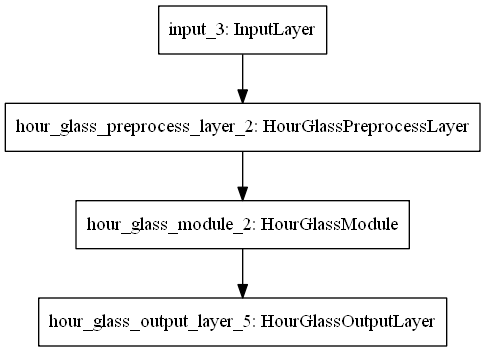

In [23]:
keras.utils.plot_model(model)

In [24]:
es = keras.callbacks.EarlyStopping(monitor = "val_loss", min_delta = 0.0005, patience = 30, restore_best_weights = True)
lr = keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = np.log10(3), patience = 5, verbose = 1, min_delta = 0.0005)
#cp = keras.callbacks.ModelCheckpoint("current_best_model", monitor = 'val_loss', verbose = 1, save_best_only = True, mode='auto', save_freq = 1)

history = model.fit(trainData, epochs = 100, batch_size = batch_size, callbacks = [lr, es], validation_data = validData)

Epoch 1/100


ValueError: in user code:

    C:\Users\Shadow\anaconda3\envs\KeyPoint\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Users\Shadow\anaconda3\envs\KeyPoint\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\Shadow\anaconda3\envs\KeyPoint\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Shadow\anaconda3\envs\KeyPoint\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Shadow\anaconda3\envs\KeyPoint\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Shadow\anaconda3\envs\KeyPoint\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Users\Shadow\anaconda3\envs\KeyPoint\lib\site-packages\tensorflow\python\keras\engine\training.py:759 train_step
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    C:\Users\Shadow\anaconda3\envs\KeyPoint\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:388 update_state
        self.build(y_pred, y_true)
    C:\Users\Shadow\anaconda3\envs\KeyPoint\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:318 build
        self._metrics = nest.map_structure_up_to(y_pred, self._get_metric_objects,
    C:\Users\Shadow\anaconda3\envs\KeyPoint\lib\site-packages\tensorflow\python\util\nest.py:1135 map_structure_up_to
        return map_structure_with_tuple_paths_up_to(
    C:\Users\Shadow\anaconda3\envs\KeyPoint\lib\site-packages\tensorflow\python\util\nest.py:1217 map_structure_with_tuple_paths_up_to
        assert_shallow_structure(
    C:\Users\Shadow\anaconda3\envs\KeyPoint\lib\site-packages\tensorflow\python\util\nest.py:852 assert_shallow_structure
        raise ValueError(

    ValueError: The two structures don't have the same sequence length. Input structure has length 2, while shallow structure has length 3.


In [17]:
model.save("./Model/Hourglass_Network/" + str(datetime.datetime.now())[:-10].replace(" ", "_").replace(":", ""))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./Model/Hourglass_Network/2021-02-19_2223\assets


In [20]:
test = keras.models.load_model("./Model/Hourglass_Network/2021-02-19_2223", custom_objects = {"HourGlassPreprocessLayer" : HourGlassPreprocessLayer,
                                                                                              "HourGlassModule" : HourGlassModule, 
                                                                                              "HourGlassSkipUnit" : HourGlassSkipUnit, 
                                                                                              "HourGlassLayerUnit" : HourGlassLayerUnit, 
                                                                                              "HourGlassOutputLayer" : HourGlassOutputLayer,
                                                                                              "RectifiedAdam" : tfa.optimizers.RectifiedAdam})

In [14]:
def TestGenerator(paths) :
    for i in paths.astype(str) :
        img = keras.preprocessing.image.load_img("./RawData/test_imgs/" + i, target_size = target_size)
        img = keras.preprocessing.image.img_to_array(img)
        img /= 255.
        yield (img)

testData = tf.data.Dataset.from_generator(TestGenerator, tf.float32, tf.TensorShape([target_size[0], target_size[1], 3]), args = [test_paths])
testData = testData.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)


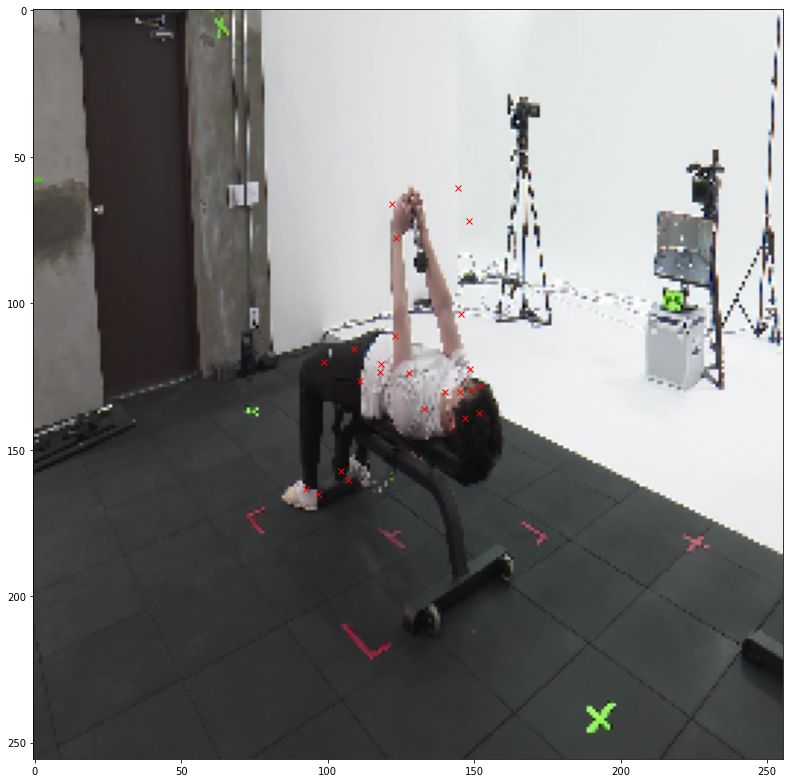

In [11]:
result = model.predict(testData)[-1]
plotData = list(testData)
testindex = 0
plotResult = model.predict(tf.expand_dims(plotData[0][testindex], axis = 0))
plotKeyPoint(plotData[0][testindex], plotResult[-1].reshape(-1))

In [18]:
submission = pd.read_csv("./RawData/sample_submission.csv")
submission.iloc[:, 1:] = result
submission.loc[:, submission.columns[x_coord]] = ((submission.loc[:, submission.columns[x_coord]]) / target_size[0]) * 1920
submission.loc[:, submission.columns[y_coord]] = ((submission.loc[:, submission.columns[y_coord]]) / target_size[1]) * 1080

In [19]:
submission.to_csv("./Submission/" + str(datetime.datetime.now())[:-10].replace(" ", "_").replace(":", "") + ".csv", index = False)